In [1]:
import torch
import gym
import time
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline 
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
env = gym.make('Acrobot-v1')
env.seed(0)
print('State shape: ', env.observation_space.shape)
print('Number of actions: ', env.action_space.n)

State shape:  (6,)
Number of actions:  3


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Critic(nn.Module):  #gives score of how bad or good the action is 
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed= 12):
        
        super(Critic, self).__init__()
        self.seed = torch.manual_seed(seed)
        "*** YOUR CODE HERE ***"
        self.fc1 = nn.Linear(state_size, 32)
        self.fc2 = nn.Linear(32, 32)
        self.fc3 = nn.Linear(32, action_size)

#     def forward(self, state):
#         """Build a network that maps state -> action values."""
#         x = self.fc1(state)
#         x = torch.tanh(x)
#         x = self.fc2(x)
#         x = torch.tanh(x)
#         x = self.fc3(x)
#         x = torch.tanh(x)   #using tanh for giving score of how good is action 
#         return x

    def forward(self, state):
        """Build a network that maps state -> action values."""
        x = self.fc1(state)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.relu(x)   #using tanh for giving score of how good is action 
        return x

    
class Actor(nn.Module):     #Policy Network
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed= 12):
        
        super(Actor, self).__init__()
        self.seed = torch.manual_seed(seed)
        "*** YOUR CODE HERE ***"
        self.fc1 = nn.Linear(state_size, 32)
        self.fc2 = nn.Linear(32, 32)
        self.fc3 = nn.Linear(32,action_size)
        self.final = nn.Sigmoid()

    def forward(self, state):
        """Build a network that maps state -> action values."""
        x = self.fc1(state)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = self.final(x)    #using sigmoid in an action 
        return x    
    
device = 'cuda' if torch.cuda.is_available() else 'cpu'
actor = Actor(6,3,12).to(device)
critic = Critic(6,3,12).to(device)

import torch.optim as optim
optimizer = optim.Adam(actor.parameters(), lr=1e-4)
optimizer_critic = optim.Adam(critic.parameters(), lr=1e-4)
print(actor)
print(critic)

Actor(
  (fc1): Linear(in_features=6, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=3, bias=True)
  (final): Sigmoid()
)
Critic(
  (fc1): Linear(in_features=6, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=3, bias=True)
)


In [4]:
device

'cuda'

In [5]:
# Testing the network
for _ in range(5):
    state = env.reset()
    for i in range(100):
        env.render()
        state_tensor = torch.from_numpy(state).float().to(device)
        prob = actor.forward(state_tensor)
        action = prob.argmax()
        prob = max(prob)
        action_baseline = critic.forward(state_tensor)
        next_state, reward, done, _ = env.step(action)
        state = next_state
        print('\rReward {} with action {} with score {}'.format(reward, action, action_baseline), end = ' ')
        if done:
            break

Reward -1.0 with action 0 with score tensor([0.1019, 0.0000, 0.0000], device='cuda:0', grad_fn=<ReluBackward0>)        

### Actual Making of Network using ppo Policy Network

In [6]:
def clipped_surrogate(policy, old_probs, states, actions, rewards, next_states,
                      discount=0.995,
                      epsilon=0.1, beta=0.01,
                     gamma = 0.1):

    states = torch.from_numpy(np.array(states)).float().to(device)
    next_states = torch.from_numpy(np.array(next_states)).float().to(device)
    
    discount = discount**np.arange(len(rewards))
    rewards_te = np.multiply(rewards, discount).reshape(len(rewards),1)
    rewards_future = rewards_te[::-1].cumsum(axis=0)[::-1]
    actions = np.array(actions, dtype=np.int8)
    actions_final = torch.LongTensor(actions.reshape(len(actions),1))
    
#     # adding contribution of actor
#     f1 = critic.forward(next_states).argmax(1).reshape(len(next_states),1)
#     f2 = torch.LongTensor(f1.cpu().reshape(f1.size()[0],1))
#     f3 = torch.gather(f1,1,f2.to(device))
    
# #     f1 = critic.forward(states).argmax(1).reshape(len(next_states),1)
# #     f2 = torch.LongTensor(f1.cpu().reshape(f1.size()[0],1))
# #     f4 = torch.gather(f1,1,f2.to(device))
#     f1 = critic.forward(states)
#     f4 = torch.gather(f1,1,actions_final.to(device))
    
#     rewards_future = rewards_future + gamma*f3.detach().cpu().numpy() - f4.detach().cpu().numpy()
#     ##end
    mean = np.mean(rewards_future, axis = 0)
    std = np.std(rewards_future, axis = 0)
    rewards_normalized = (rewards_future - mean)/std
    
    old_probs = torch.tensor(old_probs, dtype=torch.float, device=device).reshape(len(old_probs),1)
    rewards = torch.tensor(rewards_normalized, dtype=torch.float, device=device)
    
    g = actor.forward(states)
    new_probs = torch.gather(g,1,actions_final.to(device))
    
    ratio = new_probs/old_probs
#     # clipped function
    clip = torch.clamp(ratio, 1-epsilon, 1+epsilon)
    clipped_surrogate = torch.min(ratio*rewards, clip*rewards)

    
    # include a regularization term
    # this steers new_policy towards 0.5
    # add in 1.e-10 to avoid log(0) which gives nan
    entropy = -(new_probs*torch.log(old_probs+1.e-10)+ \
        (1.0-new_probs)*torch.log(1.0-old_probs+1.e-10))
    
    return torch.mean(clipped_surrogate + beta*entropy)

In [7]:
def update_baseline(next_state, reward, state):
    next_state = torch.from_numpy(np.array(next_state)).to(device).float()
    reward = torch.from_numpy(np.array(reward)).to(device)
    state = torch.from_numpy(np.array(state)).to(device).float()
    Loss = F.mse_loss(critic.forward(state), reward + critic.forward(next_state))
    optimizer_critic.zero_grad()
    Loss.backward()
    optimizer_critic.step()

In [8]:
def collect_trajectories(envs, policy, tmax=200):
    state = env.reset()
    states = []
    actions = []
    rewards = []
    probs = []
    next_states = []
    
    for _ in range(tmax):
        prob = actor(torch.from_numpy(state).float().to(device))   #for converting state to torch variable 
        prob_new = max(prob)
        probs.append(prob_new)
        states.append(state)
        action = prob.argmax()
        next_state, reward, done , _ = env.step(action)
#         update_baseline(next_state, reward,state)
        next_states.append(next_state)
        rewards.append(reward)
        actions.append(action)
        state = next_state
        if done:
            break
            
    return probs, states, actions, rewards, next_states

In [9]:
probs, states, actions, rewards, next_states = collect_trajectories(env, actor, tmax=200)

In [10]:
discount_rate = .99
epsilon = 0.1
beta = .01
tmax = 200
SGD_epoch = 4
episode = 1000

Episode: 20, score: -200.000000
-200.0


Episode: 40, score: -200.000000
-200.0


Episode: 60, score: -200.000000
-200.0


Episode: 80, score: -200.000000
-200.0


Episode: 100, score: -200.000000
-200.0


Episode: 120, score: -200.000000
-200.0


Episode: 140, score: -200.000000
-200.0


Episode: 160, score: -200.000000
-200.0


Episode: 180, score: -200.000000
-200.0


Episode: 200, score: -200.000000
-200.0


Episode: 220, score: -200.000000
-200.0


Episode: 240, score: -200.000000
-200.0


Episode: 260, score: -200.000000
-200.0


Episode: 280, score: -200.000000
-200.0


Episode: 300, score: -200.000000
-200.0


Episode: 320, score: -200.000000
-200.0


Episode: 340, score: -200.000000
-200.0


Episode: 360, score: -200.000000
-200.0


Episode: 380, score: -200.000000
-200.0


Episode: 400, score: -200.000000
-200.0


Episode: 420, score: -200.000000
-200.0


Episode: 440, score: -200.000000
-200.0


Episode: 460, score: -200.000000
-200.0


Episode: 480, score: -200.000000
-200.0


Episode: 500, score: -200.000000
-200.0


Episode: 520, score: -200.000000
-200.0


Episode: 540, score: -200.000000
-200.0


Episode: 560, score: -200.000000
-200.0


Episode: 580, score: -200.000000
-200.0


Episode: 600, score: -200.000000
-200.0


Episode: 620, score: -200.000000
-200.0


Episode: 640, score: -200.000000
-200.0


Episode: 660, score: -200.000000
-200.0


Episode: 680, score: -200.000000
-200.0


Episode: 700, score: -200.000000
-200.0


Episode: 720, score: -200.000000
-200.0


Episode: 740, score: -200.000000
-200.0


Episode: 760, score: -200.000000
-200.0


Episode: 780, score: -200.000000
-200.0


Episode: 800, score: -200.000000
-200.0


Episode: 820, score: -200.000000
-200.0


Episode: 840, score: -200.000000
-200.0


Episode: 860, score: -200.000000
-200.0


Episode: 880, score: -200.000000
-200.0


Episode: 900, score: -200.000000
-200.0


Episode: 920, score: -200.000000
-200.0


Episode: 940, score: -200.000000
-200.0


Episode: 960, score: -200.000000
-200.0


Episode: 980, score: -200.000000
-200.0


Episode: 1000, score: -200.000000
-200.0


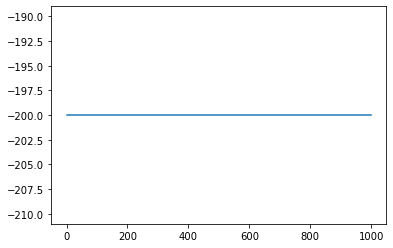

In [11]:
import progressbar as pb

widget = ['training loop: ', pb.Percentage(), ' ', 
          pb.Bar(), ' ', pb.ETA() ]
timer = pb.ProgressBar(widgets=widget, maxval=episode).start()
#following generate sim_nos instance of simulation 
envs = gym.make('Acrobot-v1')
mean_rewards = []
for e in range(episode):

    # collect trajectories
    old_probs, states, actions, rewards, next_states = \
    collect_trajectories(envs, actor, tmax=tmax)  
    total_rewards = np.sum(rewards, axis=0)
    
    # this is the SOLUTION!
    # use your own surrogate function
    # L = -surrogate(policy, old_probs, states, actions, rewards, beta=beta)
    for _ in range(SGD_epoch):
        L = -1*clipped_surrogate(actor, old_probs, states, actions, rewards, next_states, epsilon=epsilon, beta=beta)
        optimizer.zero_grad()
        L.backward()
        optimizer.step()
        del L

    epsilon*=0.999
    # the regulation term also reduces
    # this reduces exploration in later runs
    beta*=.995
    
    # get the average reward of the parallel environments
    mean_rewards.append(np.mean(total_rewards))
    
    # display some progress every 20 iterations
    if (e+1)%20 ==0 :
        print("Episode: {0:d}, score: {1:f}".format(e+1,np.mean(total_rewards)))
        print(total_rewards)
        
    # update progress widget bar
    timer.update(e+1)
    
    if(np.mean(total_rewards) == 200):
        break
    
timer.finish()
plt.plot(mean_rewards)
    

### Testing 

In [ ]:
actor.forward(state_tensor)

In [ ]:
# Testing the network
for _ in range(5):
    state = env.reset()
    for i in range(100):
        env.render()
        state_tensor = torch.from_numpy(state).float().to(device)
        prob = actor.forward(state_tensor)
        action_baseline = critic.forward(state_tensor)
        action = prob.argmax()
        next_state, reward, done, _ = env.step(action)
        state = next_state
        print('\rReward {} with action {} with critic baseline {} {}'.format(reward, action, action_baseline, prob), end = ' ')
        if done:
            break

In [ ]:
env.close()

In [ ]:
torch.save(a)